In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym as gym
from gym import spaces

In [28]:
# Load dataset
df = pd.read_csv("metrics-with-output scal.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [29]:
# Menampilkan baris pertama dari data set
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


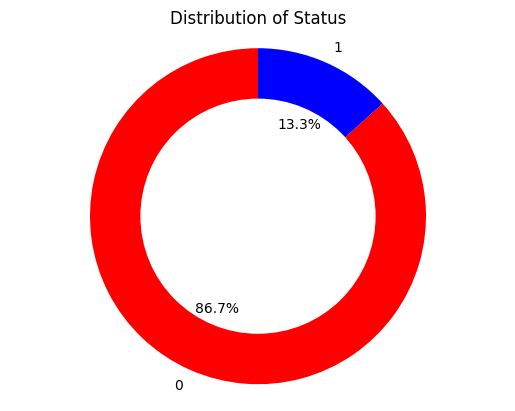

In [30]:

# Membandingkan jumlah status healthy dan unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red', 'blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
# menambahkan lingkaran tengah untuk membuat donut chart
plt.gca().add_artist(plt.Circle((0,0), 0.70, fc='white'))
# memastikan lingkaran berukuran sama sehingga terlihat seperti donus
plt.axis('equal')

plt.title('Distribution of Status')
plt.show()

In [31]:
print(df.dtypes)

Time                  object
Timestamp              int64
cpu_usage             object
memory_usage          object
bandwidth_inbound     object
bandwidth_outbound    object
tps                   object
tps_error             object
response_time         object
Status                 int64
dtype: object


In [32]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype(float) / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [33]:
# Info dataset mengenai tipe, jumlah kolom, dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [34]:
# Menampilkan dataset setelah konversi
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [35]:
# Pembersihan dan penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)
dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [36]:
from sklearn.preprocessing import LabelEncoder

# Encode Status ke numerik
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [37]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [38]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Terdapat missing values yang perlu diimputasi")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset")

Tidak ada missing values dalam dataset


In [39]:
# Split data menjadi feature (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [40]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [42]:
# Mendefinisikan model ppo
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(p=0.3)  # Menambahkan dropout

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PPO:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.93, k_epochs=5, eps_clip=0.1):
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = PolicyNetwork(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = torch.softmax(self.policy_old(state), dim=-1)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-3)

        old_states = torch.squeeze(torch.stack(memory.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(memory.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs, dim=0)).detach().to(device)

        for _ in range(self.k_epochs):
            action_probs = torch.softmax(self.policy(old_states), dim=-1)
            dist = Categorical(action_probs)
            logprobs = dist.log_prob(old_actions)
            entropy = dist.entropy()

            ratios = torch.exp(logprobs - old_logprobs)

            advantages = rewards - rewards.mean()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            state_values = self.policy(old_states).max(dim=1).values

            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*entropy.mean()

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())



class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

    def add_action(self, action):
        self.actions.append(action)

    def add_state(self, state):
        self.states.append(state)

    def add_logprob(self, logprob):
        self.logprobs.append(logprob)

    def add_reward(self, reward):
        self.rewards.append(reward)

    def add_is_terminal(self, is_terminal):
        self.is_terminals.append(is_terminal)


In [43]:
# Mendefinisikan Environment
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Load data dari data set
        self.df = dataset

        # Mendefinisikan action dan observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float64)

        self.curent_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        self.curent_step += 1
        done = self.curent_step >= len(self.df) - 1

        reward = self._get_reward(action)
        next_state = self._get_observation()

        return next_state, reward, done, {}

    def _get_observation(self):
        return self.df.iloc[self.current_step][['cpu_usage', 'memory_usage', 'bandwidth_inbound', 'bandwidth_outbound', 'tps', 'tps_error', 'response_time']].values

    def _get_reward(self, action):
        if action == self.df.iloc[self.current_step]['Status']:
            return 1.0
        else:
            return -1.0


In [44]:
len(dataset)

7189

In [45]:
# Training Model PPO

env = CustomEnv()

# Use the custom environment with the PPO algorithm
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo = PPO(state_dim, action_dim)
memory = Memory()

max_episodes = 1800
max_timesteps = 2000
update_timestep = 2000
print_freq = 1

time_step = 0
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for t in range(max_timesteps):
        time_step += 1
        action, logprob = ppo.select_action(state)
        next_state, reward, done, _ = env.step(action)


        # memory.add_state(torch.FloatTensor(state))
        memory.add_state(torch.FloatTensor(state))
        memory.add_action(torch.tensor(action))
        memory.add_logprob(torch.tensor(logprob))
        memory.add_reward(reward)
        memory.add_is_terminal(done)

        state = next_state
        episode_reward += reward


        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0

        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % print_freq == 0:
        print("Episode {} \t Total reward: {}".format(episode, episode_reward))




C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 1 	 Total reward: 820.0


C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 2 	 Total reward: 1180.0


C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 3 	 Total reward: 1458.0


C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 4 	 Total reward: 1010.0
Episode 5 	 Total reward: 1.0
Episode 6 	 Total reward: 1.0
Episode 7 	 Total reward: 1.0
Episode 8 	 Total reward: 1.0
Episode 9 	 Total reward: 1.0
Episode 10 	 Total reward: 1.0
Episode 11 	 Total reward: 1.0
Episode 12 	 Total reward: 1.0
Episode 13 	 Total reward: 1.0
Episode 14 	 Total reward: 1.0
Episode 15 	 Total reward: 1.0
Episode 16 	 Total reward: 1.0
Episode 17 	 Total reward: 1.0
Episode 18 	 Total reward: -1.0
Episode 19 	 Total reward: 1.0
Episode 20 	 Total reward: 1.0
Episode 21 	 Total reward: 1.0
Episode 22 	 Total reward: 1.0
Episode 23 	 Total reward: 1.0
Episode 24 	 Total reward: 1.0
Episode 25 	 Total reward: 1.0
Episode 26 	 Total reward: 1.0
Episode 27 	 Total reward: 1.0
Episode 28 	 Total reward: 1.0
Episode 29 	 Total reward: 1.0
Episode 30 	 Total reward: 1.0
Episode 31 	 Total reward: 1.0
Episode 32 	 Total reward: 1.0
Episode 33 	 Total reward: 1.0
Episode 34 	 Total reward: 1.0
Episode 35 	 Total reward: 1.0
Episode 36

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 278 	 Total reward: 1.0
Episode 279 	 Total reward: 1.0
Episode 280 	 Total reward: 1.0
Episode 281 	 Total reward: -1.0
Episode 282 	 Total reward: -1.0
Episode 283 	 Total reward: 1.0
Episode 284 	 Total reward: 1.0
Episode 285 	 Total reward: 1.0
Episode 286 	 Total reward: 1.0
Episode 287 	 Total reward: 1.0
Episode 288 	 Total reward: 1.0
Episode 289 	 Total reward: 1.0
Episode 290 	 Total reward: 1.0
Episode 291 	 Total reward: 1.0
Episode 292 	 Total reward: 1.0
Episode 293 	 Total reward: 1.0
Episode 294 	 Total reward: 1.0
Episode 295 	 Total reward: 1.0
Episode 296 	 Total reward: 1.0
Episode 297 	 Total reward: 1.0
Episode 298 	 Total reward: 1.0
Episode 299 	 Total reward: 1.0
Episode 300 	 Total reward: 1.0
Episode 301 	 Total reward: 1.0
Episode 302 	 Total reward: 1.0
Episode 303 	 Total reward: 1.0
Episode 304 	 Total reward: 1.0
Episode 305 	 Total reward: 1.0
Episode 306 	 Total reward: 1.0
Episode 307 	 Total reward: 1.0
Episode 308 	 Total reward: 1.0
Episod

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 507 	 Total reward: 1.0
Episode 508 	 Total reward: 1.0
Episode 509 	 Total reward: 1.0
Episode 510 	 Total reward: 1.0
Episode 511 	 Total reward: 1.0
Episode 512 	 Total reward: 1.0
Episode 513 	 Total reward: 1.0
Episode 514 	 Total reward: 1.0
Episode 515 	 Total reward: 1.0
Episode 516 	 Total reward: 1.0
Episode 517 	 Total reward: 1.0
Episode 518 	 Total reward: 1.0
Episode 519 	 Total reward: 1.0
Episode 520 	 Total reward: 1.0
Episode 521 	 Total reward: 1.0
Episode 522 	 Total reward: 1.0
Episode 523 	 Total reward: 1.0
Episode 524 	 Total reward: 1.0
Episode 525 	 Total reward: 1.0
Episode 526 	 Total reward: 1.0
Episode 527 	 Total reward: 1.0
Episode 528 	 Total reward: 1.0
Episode 529 	 Total reward: 1.0
Episode 530 	 Total reward: 1.0
Episode 531 	 Total reward: 1.0
Episode 532 	 Total reward: 1.0
Episode 533 	 Total reward: 1.0
Episode 534 	 Total reward: 1.0
Episode 535 	 Total reward: -1.0
Episode 536 	 Total reward: 1.0
Episode 537 	 Total reward: 1.0
Episode

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 779 	 Total reward: 1.0
Episode 780 	 Total reward: 1.0
Episode 781 	 Total reward: 1.0
Episode 782 	 Total reward: 1.0
Episode 783 	 Total reward: 1.0
Episode 784 	 Total reward: 1.0
Episode 785 	 Total reward: 1.0
Episode 786 	 Total reward: 1.0
Episode 787 	 Total reward: 1.0
Episode 788 	 Total reward: 1.0
Episode 789 	 Total reward: 1.0
Episode 790 	 Total reward: 1.0
Episode 791 	 Total reward: 1.0
Episode 792 	 Total reward: 1.0
Episode 793 	 Total reward: 1.0
Episode 794 	 Total reward: 1.0
Episode 795 	 Total reward: 1.0
Episode 796 	 Total reward: 1.0
Episode 797 	 Total reward: 1.0
Episode 798 	 Total reward: 1.0
Episode 799 	 Total reward: 1.0
Episode 800 	 Total reward: 1.0
Episode 801 	 Total reward: 1.0
Episode 802 	 Total reward: 1.0
Episode 803 	 Total reward: 1.0
Episode 804 	 Total reward: 1.0
Episode 805 	 Total reward: 1.0
Episode 806 	 Total reward: -1.0
Episode 807 	 Total reward: 1.0
Episode 808 	 Total reward: 1.0
Episode 809 	 Total reward: 1.0
Episode

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 965 	 Total reward: 1.0
Episode 966 	 Total reward: 1.0
Episode 967 	 Total reward: 1.0
Episode 968 	 Total reward: 1.0
Episode 969 	 Total reward: 1.0
Episode 970 	 Total reward: 1.0
Episode 971 	 Total reward: 1.0
Episode 972 	 Total reward: 1.0
Episode 973 	 Total reward: 1.0
Episode 974 	 Total reward: 1.0
Episode 975 	 Total reward: 1.0
Episode 976 	 Total reward: 1.0
Episode 977 	 Total reward: 1.0
Episode 978 	 Total reward: 1.0
Episode 979 	 Total reward: 1.0
Episode 980 	 Total reward: 1.0
Episode 981 	 Total reward: 1.0
Episode 982 	 Total reward: 1.0
Episode 983 	 Total reward: 1.0
Episode 984 	 Total reward: 1.0
Episode 985 	 Total reward: 1.0
Episode 986 	 Total reward: 1.0
Episode 987 	 Total reward: 1.0
Episode 988 	 Total reward: 1.0
Episode 989 	 Total reward: 1.0
Episode 990 	 Total reward: 1.0
Episode 991 	 Total reward: 1.0
Episode 992 	 Total reward: 1.0
Episode 993 	 Total reward: 1.0
Episode 994 	 Total reward: 1.0
Episode 995 	 Total reward: 1.0
Episode 

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 1203 	 Total reward: 1.0
Episode 1204 	 Total reward: 1.0
Episode 1205 	 Total reward: 1.0
Episode 1206 	 Total reward: 1.0
Episode 1207 	 Total reward: 1.0
Episode 1208 	 Total reward: 1.0
Episode 1209 	 Total reward: 1.0
Episode 1210 	 Total reward: -1.0
Episode 1211 	 Total reward: 1.0
Episode 1212 	 Total reward: 1.0
Episode 1213 	 Total reward: 1.0
Episode 1214 	 Total reward: 1.0
Episode 1215 	 Total reward: 1.0
Episode 1216 	 Total reward: 1.0
Episode 1217 	 Total reward: 1.0
Episode 1218 	 Total reward: 1.0
Episode 1219 	 Total reward: 1.0
Episode 1220 	 Total reward: 1.0
Episode 1221 	 Total reward: 1.0
Episode 1222 	 Total reward: 1.0
Episode 1223 	 Total reward: 1.0
Episode 1224 	 Total reward: 1.0
Episode 1225 	 Total reward: 1.0
Episode 1226 	 Total reward: -1.0
Episode 1227 	 Total reward: 1.0
Episode 1228 	 Total reward: 1.0
Episode 1229 	 Total reward: -1.0
Episode 1230 	 Total reward: 1.0
Episode 1231 	 Total reward: 1.0
Episode 1232 	 Total reward: 1.0
Episode

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

Episode 1455 	 Total reward: 1.0
Episode 1456 	 Total reward: 1.0
Episode 1457 	 Total reward: 1.0
Episode 1458 	 Total reward: 1.0
Episode 1459 	 Total reward: 1.0
Episode 1460 	 Total reward: -1.0
Episode 1461 	 Total reward: 1.0
Episode 1462 	 Total reward: 1.0
Episode 1463 	 Total reward: 1.0
Episode 1464 	 Total reward: -1.0
Episode 1465 	 Total reward: 1.0
Episode 1466 	 Total reward: 1.0
Episode 1467 	 Total reward: -1.0
Episode 1468 	 Total reward: 1.0
Episode 1469 	 Total reward: 1.0
Episode 1470 	 Total reward: 1.0
Episode 1471 	 Total reward: 1.0
Episode 1472 	 Total reward: 1.0
Episode 1473 	 Total reward: 1.0
Episode 1474 	 Total reward: 1.0
Episode 1475 	 Total reward: 1.0
Episode 1476 	 Total reward: 1.0
Episode 1477 	 Total reward: 1.0
Episode 1478 	 Total reward: 1.0
Episode 1479 	 Total reward: 1.0
Episode 1480 	 Total reward: 1.0
Episode 1481 	 Total reward: 1.0
Episode 1482 	 Total reward: 1.0
Episode 1483 	 Total reward: 1.0
Episode 1484 	 Total reward: 1.0
Episode

C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_16984\3800787374.py:31: UserWarning:

In [46]:
# Evaluasi model PPO
def evaluate_policy(env, model, n_eval_episodes=10, isPredict=False):
    episode_rewards = []
    predicted_statuses = []
    for _ in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                predicted_statuses.append(action)  # Save the predicted action as the status
        episode_rewards.append(episode_reward)
    if not isPredict:
        mean_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)
        return mean_reward, std_reward

    return episode_rewards, predicted_statuses

mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


Mean reward: 1.0 +/- 0.0


Episode: 1, Score: 1.0
Episode: 2, Score: 1.0
Episode: 3, Score: -1.0
Episode: 4, Score: 1.0
Episode: 5, Score: 1.0
Episode: 6, Score: 1.0
Episode: 7, Score: 1.0
Episode: 8, Score: 1.0
Episode: 9, Score: 1.0
Episode: 10, Score: 1.0
Episode: 11, Score: 1.0
Episode: 12, Score: 1.0
Episode: 13, Score: 1.0
Episode: 14, Score: 1.0
Episode: 15, Score: 1.0
Episode: 16, Score: 1.0
Episode: 17, Score: 1.0
Episode: 18, Score: 1.0
Episode: 19, Score: 1.0
Episode: 20, Score: 1.0
Episode: 21, Score: 1.0
Episode: 22, Score: 1.0
Episode: 23, Score: -1.0
Episode: 24, Score: 1.0
Episode: 25, Score: 1.0
Episode: 26, Score: 1.0
Episode: 27, Score: 1.0
Episode: 28, Score: 1.0
Episode: 29, Score: 1.0
Episode: 30, Score: 1.0
Episode: 31, Score: 1.0
Episode: 32, Score: 1.0
Episode: 33, Score: 1.0
Episode: 34, Score: 1.0
Episode: 35, Score: 1.0
Episode: 36, Score: 1.0
Episode: 37, Score: -1.0
Episode: 38, Score: 1.0
Episode: 39, Score: 1.0
Episode: 40, Score: 1.0
Episode: 41, Score: 1.0
Episode: 42, Score: 1.

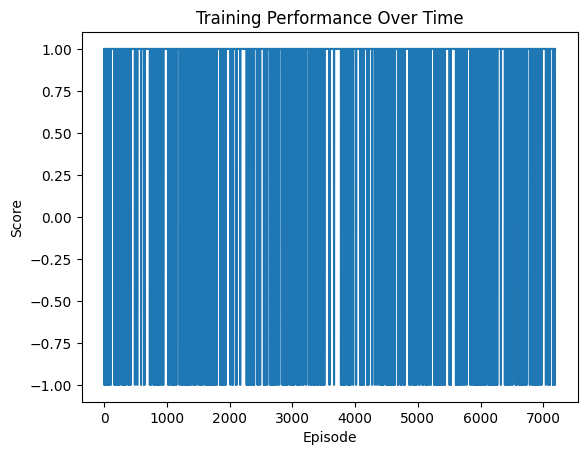

In [47]:
# Visualisasi hasil training
episodes = len(dataset['Status'])
scores = []
for episode in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action, _ = ppo.select_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    scores.append(score)
    print(f"Episode: {episode}, Score: {score}")

env.close()

# Plotting the scores
plt.plot(range(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Performance Over Time')
plt.show()


   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound  tps  \
0      0.090         0.535               7.46                6.45  2.0   
1      0.166         0.533               5.85                5.27  2.2   
2      0.202         0.553               9.06                7.96  3.2   
3      0.146         0.580               8.41                7.21  3.2   
4      0.102         0.535               4.88                4.30  2.6   

   tps_error  response_time  Status  
0        0.0          0.607       0  
1        0.0          2.090       0  
2        0.0          3.450       0  
3        0.0          2.580       0  
4        0.0          0.862       0  
      Actual Status  Predicted Status
0                 0                 0
1                 0                 0
2                 0                 0
3                 0                 0
4                 0                 0
...             ...               ...
1795              0                 0
1796              0    

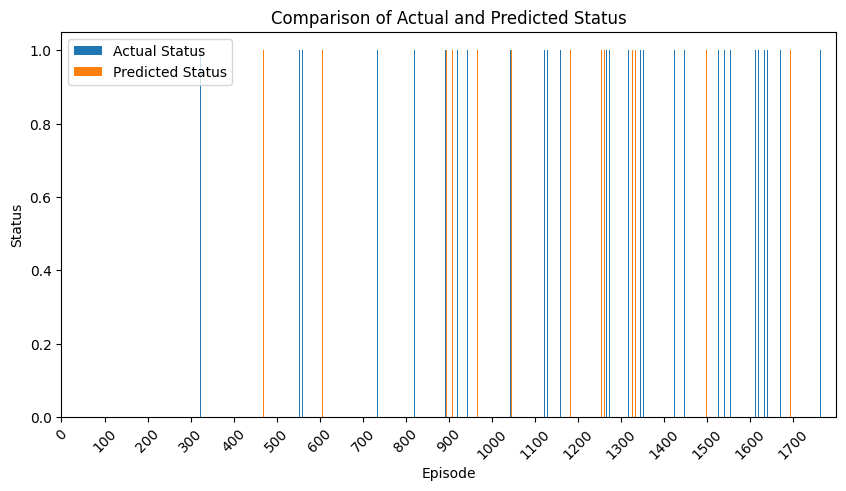

In [64]:
# Load actual data for comparison
actual_data = dataset
print(actual_data.head())

predicted_statuses = []
actual_statuses = actual_data['Status'].tolist()


# Evaluasi dan dapatkan predicted status
mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=max_episodes)
_, predicted_statuses = evaluate_policy(env, ppo, n_eval_episodes=max_episodes, isPredict=True)

# Comparison
comparison_df = pd.DataFrame({
    'Actual Status': actual_statuses[:len(predicted_statuses)],  # Ensure matching length
    'Predicted Status': predicted_statuses
})

print(comparison_df)

# Visualization
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Episode')
step = 100  # setiap 100 episode
ticks = np.arange(0, len(predicted_statuses), step)
plt.xticks(ticks, rotation=45)
plt.ylabel('Status')
plt.title('Comparison of Actual and Predicted Status')
plt.show()


In [49]:
len(predicted_statuses)

1800

Confusion Matrix - Validation Data
[[1161   67]
 [ 197   13]]


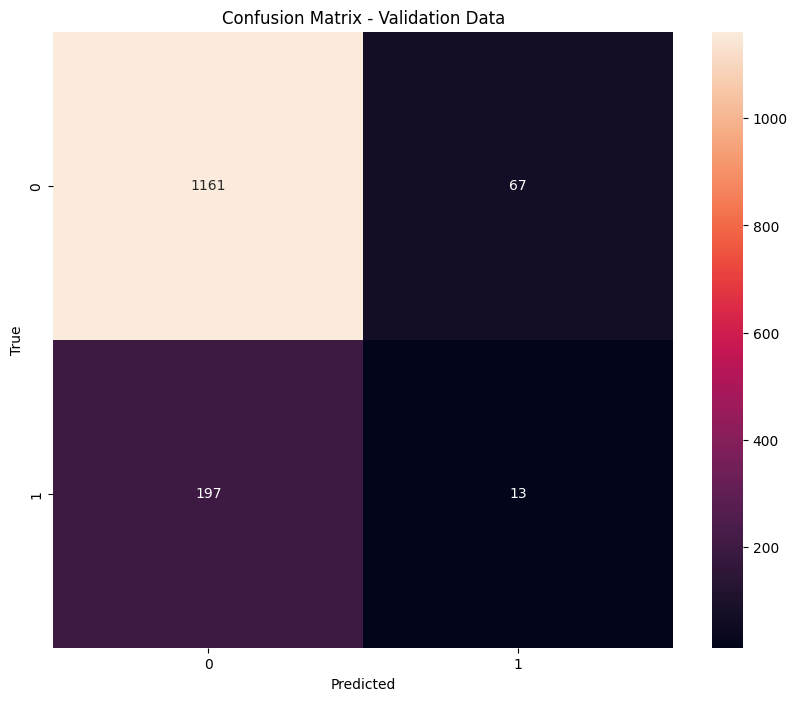

Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1228
           1       0.16      0.06      0.09       210

    accuracy                           0.82      1438
   macro avg       0.51      0.50      0.49      1438
weighted avg       0.75      0.82      0.78      1438



In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Menghitung dan menampilkan confusion matrix untuk data validasi
cm_val = confusion_matrix(y_test, predicted_statuses[:1438])
print("Confusion Matrix - Validation Data")
print(cm_val)

# Menampilkan confusion matrix sebagai heatmap untuk data validasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Menghitung dan menampilkan classification report untuk data validasi
print("Classification Report - Validation Data")
report_val = classification_report(y_test, predicted_statuses[:1438])
print(report_val)

In [51]:
np.unique(predicted_statuses)

array([0, 1])

In [52]:
# print(f"Best Hyperparameters: Learning Rate: {best_params[0]}, Gamma: {best_params[1]}, Epsilon Clip: {best_params[2]}, K Epochs: {best_params[3]}")